<a href="https://colab.research.google.com/github/datajcthemax/playdata/blob/main/day31_Segmentation_ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 31번째 이야기
- Segmentation - UNET
- ObjectDetection - YOLO

![1_qNdglJ1ORP3Gq77MmBLhHQ[1].png](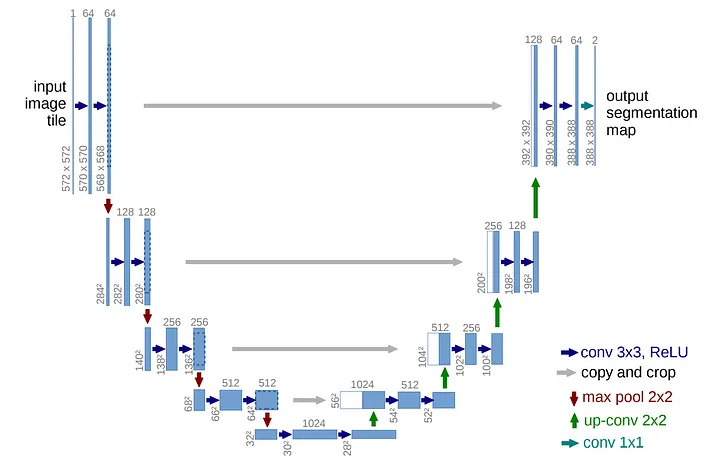)

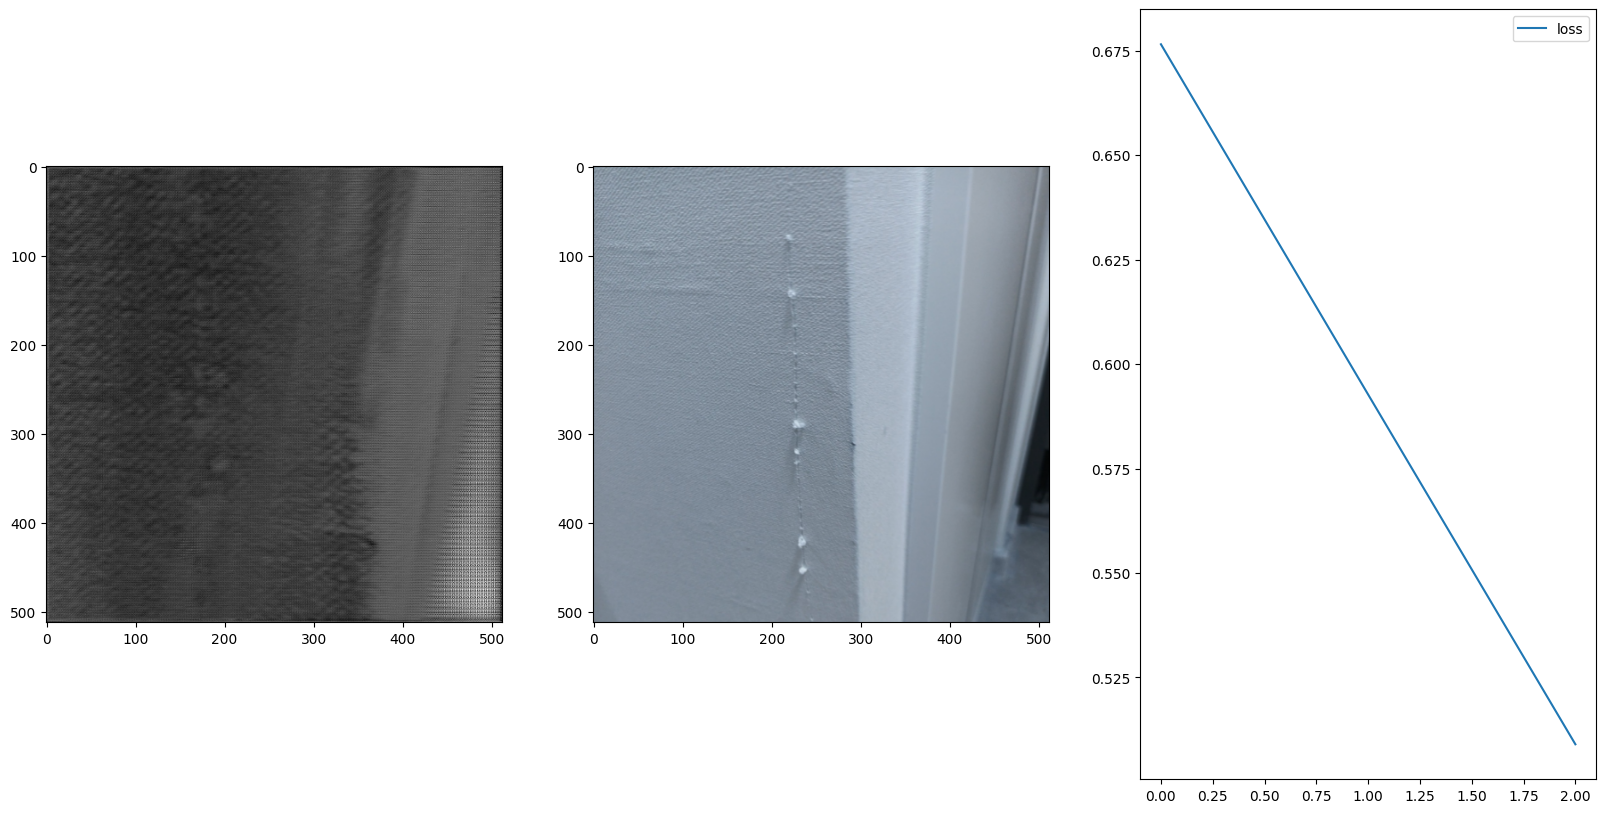

KeyboardInterrupt: ignored

In [ ]:
import pickle
import matplotlib.pyplot as plt
import os
path = '/content/drive/MyDrive/datas/'
# pickle 다루기
with open(path+'X.pkl', 'rb') as f:
  X = pickle.load(f)
with open(path+'y.pkl', 'rb') as f:
  y = pickle.load(f)

""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        logits = self.sigmoid(x)
        
        return logits

import torch.optim as optim
from torch.utils.data import DataLoader
import cv2

# hyper parameters
epochs = 500
batch_size = 4
learning_rate = 1e-3

width = 512
height = 512

def prepare_data(img):
  # 사이즈 바꾸고
  img = cv2.resize(img, (height,width))
  # 채널 위치 변경 (channels, height, width)
  img = img.reshape(3, height, -1)
  # scaling
  img = img/255. # 안하고도 해보세요
  # tensor
  img = torch.from_numpy(img).float()
  return img
train_dataset = [ (prepare_data(img), prepare_data(label)) for img, label in zip(X, y)]
train_loader = DataLoader(train_dataset, batch_size=batch_size)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet(3,1).to(device)
# criterion = nn.BCEWithLogitsLoss ()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# 모델 교육
from IPython.display import clear_output
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data.float())
        loss = criterion(output, target[:,[0],:,:].float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    clear_output()
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    plt.figure(figsize=(20,10))
    plt.subplot(2,2,1)
    plt.imshow(output.detach().cpu().numpy()[0].reshape(height, width), cmap='gray')
    plt.subplot(2,2,2)
    plt.imshow(data.detach().cpu().numpy()[0].reshape(height, width,3))
    plt.subplot(2,2,3)
    plt.imshow(target.detach().cpu().numpy()[0][0], cmap='gray')
    plt.subplot(2,2,4)
    plt.plot(losses, label='loss')
    plt.legend()
    plt.show()
    # print("Epoch: {}/{}, Loss: {:.6f}".format(epoch + 1, epochs, epoch_loss))


In [ ]:
import pickle
import matplotlib.pyplot as plt

# pickle 다루기
with open('X.pkl', 'rb') as f:
  X = pickle.load(f)
with open('y.pkl', 'rb') as f:
  y = pickle.load(f)

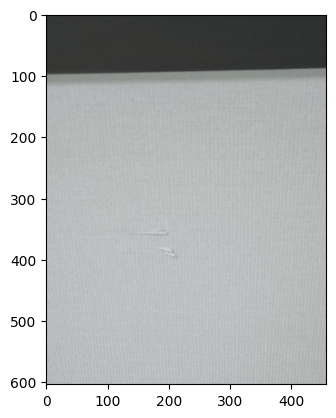

In [ ]:
plt.imshow(X[2])

In [ ]:
y[2].shape

(604, 458, 3)

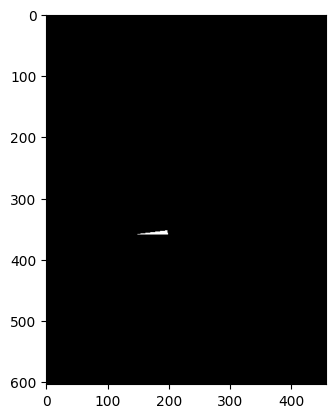

In [ ]:
plt.imshow(y[2])

In [ ]:
import torch
from torch import nn

class UNet(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    def conv_block(in_channels, out_channels):
      return nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
          nn.SiLU(inplace = True),
          nn.BatchNorm2d(out_channels)
      )
    
    self.encoder1 = nn.Sequential(
        conv_block(in_channels, in_channels*2),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.encoder2 = nn.Sequential(
        conv_block(in_channels*2, in_channels*4),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.middle = conv_block(in_channels*4, in_channels*8)

    self.decoder1 = nn.Sequential(
        nn.ConvTranspose2d(in_channels*8+in_channels*4,in_channels*4,kernel_size=2, stride=2),
        conv_block(in_channels*4,in_channels*2),
    )
    self.decoder2 = nn.Sequential(
        nn.ConvTranspose2d(in_channels*2+in_channels*2,in_channels*2,kernel_size=2, stride=2),
        conv_block(in_channels*2,out_channels),
        nn.Sigmoid()
    )
  def forward(self, x):
    x1 = self.encoder1(x)
    # print('x1',x1.shape)
    x2 = self.encoder2(x1)
    # print('x2',x2.shape)
    x3 = self.middle(x2)
    # print('x3',x3.shape)
    x23=torch.cat([x3,x2], axis=1)
    x4 = self.decoder1(x23)
    # print('x4',x4.shape)
    x14=torch.cat([x1,x4], axis=1)
    x5 = self.decoder2(x14)    
    # print('x5',x5.shape)
    return x5

In [ ]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
import cv2

# hyper parameters
epochs = 500
batch_size = 1
learning_rate = 1e-3

width = 512
height = 512

def prepare_data(img):
  # 사이즈 바꾸고
  img = cv2.resize(img, (height,width))
  # 채널 위치 변경 (channels, height, width)
  img = img.reshape(3, height, -1)
  # scaling
  img = img/255. # 안하고도 해보세요
  # tensor
  img = torch.from_numpy(img).float()
  return img

In [ ]:
train_dataset = [ (prepare_data(img), prepare_data(label)) for img, label in zip(X, y)]

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size)

## tip : pytorch-lightning

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet(3,1).to(device)
# criterion = nn.BCEWithLogitsLoss ()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# 모델 교육
from IPython.display import clear_output
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data.float())
        loss = criterion(output, target[:,[0],:,:].float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    clear_output()
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(output.detach().cpu().numpy()[0].reshape(height, width), cmap='gray')
    plt.subplot(1,2,2)
    plt.plot(losses, label='loss')
    plt.legend()
    plt.show()
    # print("Epoch: {}/{}, Loss: {:.6f}".format(epoch + 1, epochs, epoch_loss))


RuntimeError: ignored

In [ ]:
target[:,[0],:,:]

In [ ]:
import numpy as np
img = output[0][0].detach().cpu().numpy()*255
img = img.astype(np.uint8)
plt.imshow(img, cmap='gray')

In [ ]:
img

In [ ]:
output.detach().cpu().numpy()[0].reshape(height, width, 3).max()

- 이미지 출력 모니터링
- 다른 문제에 적용 - 해상도... 고민
- 구조를 더 복잡하게
- 다른 옵티마이저, 전처리 적용

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor
import cv2
# 하이퍼파라미터 설정
epochs = 50
batch_size = 8
learning_rate = 0.001

width = 500
height = 500

# 데이터셋 및 DataLoader 준비
train_transform = Compose([ToTensor()])
train_dataset = [(cv2.resize(xx, (height,width)).reshape(3,height, width)/255, cv2.resize(yy, (height,width)).reshape(3,height, width)/255) for xx, yy in zip(X, y)]
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# 모델, 손실 함수 및 옵티마이저 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, out_channels=3).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# 모델 교육
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data.float())
        loss = criterion(output, target.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print("Epoch: {}/{}, Loss: {:.6f}".format(epoch + 1, epochs, epoch_loss))


In [ ]:
a =torch.tensor([1,2,3,4,5,6])

In [ ]:
a.view(2,3)

tensor([[1, 2, 3],
        [4, 5, 6]])

In [ ]:
1 : [0.1,0.5,0.4, ....,]
2 : 

tensor([[1, 2, 3],
        [4, 5, 6]])

In [ ]:
img = torch.ones(1,28,28)

In [ ]:
l1 = nn.Linear(10,2)
l1.weight

Parameter containing:
tensor([[-0.1096,  0.2574, -0.2126, -0.0423,  0.1319,  0.2598, -0.1541, -0.2056,
          0.1939, -0.0989],
        [-0.2372, -0.1632,  0.3020,  0.2274, -0.0042, -0.0077,  0.0545, -0.0942,
         -0.0538, -0.1802]], requires_grad=True)

In [ ]:
img_ = img.reshape(1,-1)

In [ ]:
img_.shape

torch.Size([1, 784])

In [ ]:
class_info = torch.ones(1,123)

In [ ]:
torch.cat([img_, class_info], axis=-1).shape

torch.Size([1, 907])

In [ ]:
import torch

In [ ]:
torch.manual_seed(1234)

In [ ]:
torch.nn.Linear(10,2).weight

Parameter containing:
tensor([[-0.1551,  0.0818,  0.2950,  0.1518, -0.0305, -0.0153,  0.1797, -0.2198,
          0.1051, -0.1048],
        [ 0.1830, -0.1128,  0.0156,  0.1068,  0.2173, -0.0465,  0.2885, -0.2675,
         -0.0564, -0.3153]], requires_grad=True)

In [ ]:
torch.nn.Linear(10,2).weight

Parameter containing:
tensor([[-0.1280,  0.1313, -0.0513, -0.2748,  0.2428,  0.1950,  0.1599,  0.2522,
          0.1163,  0.1681],
        [ 0.2624, -0.0637, -0.2466, -0.1555, -0.0422, -0.0347, -0.0021,  0.1812,
          0.1014, -0.2338]], requires_grad=True)

In [ ]:
model.train()
model.eval()